#### Empezamos cargando las Librerias

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import datetime
from dateutil.rrule import rrule, MONTHLY
from dateutil.relativedelta import relativedelta
from keras.layers import BatchNormalization
import tensorflow as tf

#### Abrimos la data con las variables de Precipitación (RR) y Temperatura Superficial del Mar (SST)

In [31]:
BASE = pd.read_excel('DATA.xlsx', engine='openpyxl')
BASE.Fecha = pd.to_datetime(BASE.Fecha)
BASE  = BASE.set_index('Fecha')

In [32]:
BASE.describe()

,RR,SST
count,1279.000000,1279.000000
mean,95.072150,21.291413
std,154.966247,2.303559
min,0.000000,16.677064
25%,0.000000,19.361422
50%,5.700000,20.959375
75%,145.400000,23.254537
max,1124.000000,28.074939


#### Creamos el set de datos con las variables de SST desfasadas 12 meses incluida la SST sin desfase, perdemos el primer año que es el 1915.

In [33]:
S = pd.DataFrame(BASE.SST)
S = S.rename(columns={'SST': "Xt"})
S['Xt-1'] = BASE.SST.shift(1)
S['Xt-2'] = BASE.SST.shift(2)
S['Xt-3'] = BASE.SST.shift(3)
S['Xt-4'] = BASE.SST.shift(4)
S['Xt-5'] = BASE.SST.shift(5)
S['Xt-6'] = BASE.SST.shift(6)
S['Xt-7'] = BASE.SST.shift(7)
S['Xt-8'] = BASE.SST.shift(8)
S['Xt-9'] = BASE.SST.shift(9)
S['Xt-10'] = BASE.SST.shift(10)
S['Xt-11'] = BASE.SST.shift(11)
S['Xt-12'] = BASE.SST.shift(12)
S = S.dropna()
S.head

<bound method NDFrame.head of                    Xt       Xt-1       Xt-2       Xt-3       Xt-4       Xt-5  \
Fecha                                                                          
1916-01-01  21.053894  19.707229  18.287647  18.569966  18.572922  19.462845   
1916-02-01  22.599465  21.053894  19.707229  18.287647  18.569966  18.572922   
1916-03-01  23.110899  22.599465  21.053894  19.707229  18.287647  18.569966   
1916-04-01  21.392558  23.110899  22.599465  21.053894  19.707229  18.287647   
1916-05-01  19.818617  21.392558  23.110899  22.599465  21.053894  19.707229   
...               ...        ...        ...        ...        ...        ...   
2021-03-01  23.945781  23.944501  22.324693  20.825978  19.380769  18.574843   
2021-04-01  22.374807  23.945781  23.944501  22.324693  20.825978  19.380769   
2021-05-01  21.562235  22.374807  23.945781  23.944501  22.324693  20.825978   
2021-06-01  20.821750  21.562235  22.374807  23.945781  23.944501  22.324693   
2021-07-01

#### Definimos el periodo de entrenamiento desde 1916 hasta 2019, y el periodo de prueba 2020 hasta 2021, recordar que necesita el modelo un objeto de dimension 3:

* Dimension 1: El numero de observaciones que tienes
* Dimension 2: El numero de pasos en el tiempo, solo dimos 1 paso por variable
* Dimension 3: El numero de variables, tenemos 12 entradas

#### El modelo RNN requiere datos de entrada tridimensionales, por tanto rescalamos las dimensiones de entradas.

In [87]:
Y_TRAIN = BASE[(BASE.index <= '2019-12-01') & (BASE.index  >= min(S.index))]["RR"]
X_TRAIN = np.array(S[S.index <= '2019-12-01'])
X_TRAIN = X_TRAIN.reshape(len(X_TRAIN), 1, X_TRAIN.shape[1])

Y_TEST  = BASE[BASE.index > '2019-12-01']["RR"]
X_TEST  = np.array(S[S.index > '2019-12-01'])
X_TEST  = X_TEST.reshape(len(X_TEST), 1, X_TEST.shape[1])

#### Definimos la arquitectura del modelo:
* Un modelo de 2 capas recurrentes apiladas, cada una con 128 celdas de memoria, obteniendo una Red Neuronal profunda enrolada a través del tiempo.
* De forma predeterminada, las capas recurrentes en Keras solo devuelven el resultado final. Para que devuelvan una salida por paso de tiempo, debe configurar return_sequences = True.
* La forma del tamaño del modelo es una tupla de tamaño 2, 1 paso de tiempo sucesivo para las 13 variables de entrada desfasadas.
* Función de activación Relu, para un RNN simple con series de tiempo cortas, no debería haber nada malo en trabajar con la activación de ReLU, abordando la posibilidad de desvanecimiento del gradiente durante el entrenamiento.
* Sería preferible reemplazar la capa de salida con una capa Densa, se ejecutaría un poco más rápido, la precisión sería aproximadamente la misma y nos permitiría elegir cualquier remover return_sequence = True de la segunda capa recurrente.
* Agregamos 4 capas ocultas, con 64 neuronas la primera, 32 la segunda, 16 la tercera, y 1 neurona la última. La última solo estudiara 1 salida para el pronóstico. 
* Agregamos el método dropout para desactivar el 90% de las neuronas hasta la penúltima capa densa que solo tiene 16, ayudando a reducir el overfitting, para perder la dependencia entre los patrones encontrados por las neuronas cercanas.
* Agregamos el método de normalización, para evitar que existan distancias muy diferentes entre el modelo y el observado. Transforma los predictores para que estén aproximadamente en la misma escala. BatchNormalization después de nuestra primer cada Densa tomara lo aprendido en la primera capa oculta.
* El modelo se ajusta con el error cuadrático medio, el descenso del gradiente se compila con el algoritmo Adam, para mantener los pesos a una tasa de aprendizaje única, sin cambiar la tasa de aprendizaje en el proceso de entrenamiento, Adam diseña tasa de aprendizaje adaptativos independientes para los diferentes parámetros.
* La última capa densa con una salida lineal, se compila con la función de costo que se encarga de cuantificar la distancia entre el valor real y el valor predicho por la red a través del error cuadrático medio, con un loss = mse, para ajustar una perdida decreciente y una precisión en aumento.
* 100 épocas, es el número de veces que el modelo ve cada ejemplo de entrenamiento, y un 20 % de porcentajes de las muestras que el modelo usa en cada iteración para comprobar los resultados en lo entrenado.
* Fijamos una semilla para poder tener el mismo resultado calibrado cuando pasemos a producción.

In [88]:
tf.random.set_seed(-13741)
model = Sequential()
model.add(SimpleRNN(128, return_sequences=True, input_shape = (X_TRAIN.shape[1:])))
model.add(SimpleRNN(128, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mse',optimizer = 'adam')
model.fit(X_TRAIN, Y_TRAIN, epochs=100,batch_size = 100, verbose=False)

<AxesSubplot:xlabel='Fecha'>

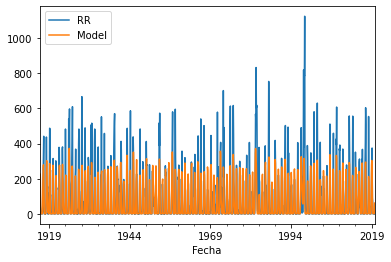

In [89]:
TRAIN = pd.DataFrame({'RR':Y_TRAIN})
TRAIN["Model"] = model.predict(X_TRAIN)
TRAIN.plot.line()

In [90]:
print('Coeficiente de Determinación Training:',round(sm.OLS(TRAIN['RR'], TRAIN['Model']).fit().rsquared_adj,2))

Coeficiente de Determinación Training: 0.73


In [91]:
print('Raiz del Error Cuadrático Medio Training: ',round(np.sqrt(mean_squared_error(TRAIN['RR'], TRAIN['Model'])),0))

Raiz del Error Cuadrático Medio Training:  98.0


<AxesSubplot:xlabel='Fecha'>

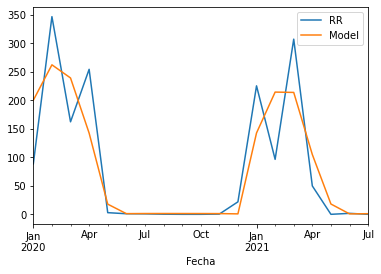

In [92]:
TEST = pd.DataFrame({'RR':Y_TEST})
TEST["Model"] = model.predict(X_TEST)
TEST.plot.line()

In [93]:
print('Coeficiente de Determinación Testing: ', round(sm.OLS(TEST['RR'], TEST['Model']).fit().rsquared_adj,2))

Coeficiente de Determinación Testing:  0.8


In [94]:
print('Raiz del Error Cuadrático Medio Testing: ',round(np.sqrt(mean_squared_error(TEST['RR'], TEST['Model'])),0))

Raiz del Error Cuadrático Medio Testing:  61.0


#### Referencias

Aurélien Géron, 2019.Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems 2nd Edición.

Jason Brownlee, 2016. Machine Learning Mastery with Python, understand your data, Create Accurate Models and Work Projects end-to-end.


Tutoriales:
 * Link: https://www.freecodecamp.org/news/the-ultimate-guide-to-recurrent-neural-networks-in-python/
 * Link: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/